# Project 1. Denoising Network

In this project, you're going to implement a neural network to denoise images, there are several parts you need to implement to make the whole pipeline complete.

1. Dataset
2. Metrics
3. Networks
4. Training

## 1. Dataset

In this project we are going to use an image dataset of 400 grayscale 180*180 images as our dataset, use command below to download the dataset

In [ ]:
!wget https://www.dropbox.com/s/o1u4rmjwpaq3y4a/ImageSet.zip?dl=0 -O ImageSet.zip
!unzip -q ImageSet.zip

--2022-04-08 13:20:43--  https://www.dropbox.com/s/o1u4rmjwpaq3y4a/ImageSet.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/o1u4rmjwpaq3y4a/ImageSet.zip [following]
--2022-04-08 13:20:43--  https://www.dropbox.com/s/raw/o1u4rmjwpaq3y4a/ImageSet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce3645f9b427342905ebe15841a.dl-au.dropboxusercontent.com/cd/0/inline/BjAMtphU41VjQcoDel_GarvRm9Tz213hqieaGZHxSfJFF5ogMzSeK3AV7PJF-a7NH6AVW6SgWM39j1BDSr4__Md7J1JVItPge9dWneeu8kqGoZ7CpYzaQ9d6N5ZlSaCzwNcjrrn1tz1W_qMGbRdSiRiJ0y3mOxY87YL13SjAIvr-VA/file# [following]
--2022-04-08 13:20:43--  https://uce3645f9b427342905ebe15841a.dl-au.dropboxusercontent.com/cd/0/inline/BjAMtphU41VjQcoDel_GarvRm9Tz213hqieaGZHxSfJFF5ogMzSeK3AV7

Now you should have a folder called ImageSet, and there're 400 images in it

In [ ]:
!nvidia-smi

Fri Apr  8 13:20:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now you need to implement two classes, TrainingSet and TestingSet, you should first split your dataset into 350 images and 50 images. TrainingSet should use the 350 images to form a dataset, with each entry being a pair of image tensors, and the first image should be a noisy version of the second original image. In other words, `training_set[i]` should return `[noisy_image(=original_image + noise), original_image]`, and images should be tensors of shape $C\times H\times W$, in this case, $1\times 180\times 180$

TestingSet is the same thing with the remaining 50 images.
1. Please refer to the following code to add noise
```python
def add_noise(img):
    noise = torch.randn(img.size()).mul_(self.sigma/255.0)
    noisy = img + noise
    noisy[torch.where(noisy > 1)] = 1
    noisy[torch.where(noisy < 0)] = 0
    return noisy
```
2. Also refer to the following code as how to read images from file to memory
```python
class RawImageSet(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        self.all_image_files = os.listdir(root)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.all_image_files[index])
        img = PIL.Image.open(image_path)
        return transforms.ToTensor()(img)

    def __len__(self):
        return len(self.all_image_files)
```

In [ ]:
# implement your TrainingSet and TestingSet here
import os 
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import torch.nn as nn
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
def add_noise(img):
    noise = torch.randn(img.size()).mul_(10/255.0)
    noisy = img + noise
    noisy[torch.where(noisy > 1)] = 1
    noisy[torch.where(noisy < 0)] = 0
    return noisy

class RawImageSet(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        self.all_image_files = os.listdir(root)
      
    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.all_image_files[index])
        img =Image.open(image_path)
        return transforms.ToTensor()(img)
       
    def __len__(self):
        return len(self.all_image_files)
    

path = "/content/ImageSet"  # It's the data-path
DataSet = RawImageSet(path)

channel_change = transforms.Grayscale(num_output_channels=1) #change the channel of the image from 3 to 1

training_set = []

for m in range(0,350): #Setting up the training set using for loop and the number of elements in the training set is 350
    original_img = channel_change(DataSet.__getitem__(m))
    noise_img = add_noise(original_img) #add the noise to original image to get the noisy image
    set_for_couple = []
    set_for_couple.append(noise_img) #add the noisy image to the list first to achieve the requirment
    set_for_couple.append(original_img)
    training_set.append(set_for_couple)

testing_set = []   

for n in range(350,400): # Setting up the testing set using for loop
    original_img =channel_change(DataSet.__getitem__(n)) #the number of elements in the testing set is 50
    noise_img =add_noise(original_img)
    set_for_couple = []
    set_for_couple.append(noise_img)
    set_for_couple.append(original_img)
    testing_set.append(set_for_couple)

You can use the following code block to check if your implementation is correct, first, there should be **no error**, second, the shape of image should be **`[1, 180, 180]`**, and finally, in the drawing area, the **left hand side image should be noisier than the right hand side image**, but they should be images of the same thing.

Shape of image: torch.Size([1, 180, 180])


Text(0.5, 1.0, 'original example')

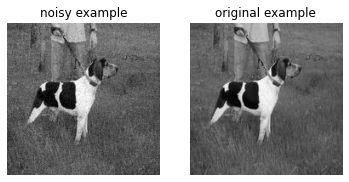

In [ ]:
assert len(training_set) == 350
assert len(testing_set) == 50

print(f'Shape of image: {training_set[0][0].shape}')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(training_set[2][0][0], cmap = 'gray')
axes[0].axis('off')
axes[0].set_title('noisy example')
axes[1].imshow(training_set[2][1][0], cmap = 'gray')
axes[1].axis('off')
axes[1].set_title('original example')

## 2. Metrics
To quantify how noisy an image is compared to the original one, we're going to use PSNR, please implement a function `psnr` to return the psnr score.

Refer to https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio about the formula of PSNR

Note:
1. higher PSNR means noise is relatively smaller, the PSNR of the original image is positive infinity, because the noise is zero.
2. the psnr is a symetric function, meaning the psnr of a noisy image with respect to the original one is the same as the psnr of the original image with respect to the noisy one.

In [ ]:
# implement your psnr function
import math
import numpy as np

def psnr(original, noisy): # The psnr function
    original = original.cpu() # To put both inputs in cpu 
    noisy = noisy.cpu()
    mse = np.mean((original.detach().numpy() - noisy.detach().numpy()) ** 2) # Firstly transfer both inputs into numpy array to calculate the mean and thus the mse
    if mse == 0:           #This only occurs when both inputs are the same 
        return 100 
    return 10*math.log10(1/mse) # the psnr

Run the following code to check if the implementation is correct, the expected output should be about 7.96

In [ ]:
import torch
test_original = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
test_noisy = torch.tensor([[0.5, 0.6], [0.7, 0.8]])
print(f'PSNR score: {psnr(test_original, test_noisy)}')

PSNR score: 7.958799866044889


And we can calculate the psnr score for the noisy image pair we showed above, the score should be aroud 28, but there could be exception.

In [ ]:
print(f'PSNR score for original images: {psnr(training_set[0][1][0], training_set[0][0][0])}')

PSNR score for original images: 28.66080026900014


## 3. Network
Now that we got dataset ready and metrics ready, we start preparing the network. You need to define a class `DenoiseNetwork` as your network class.

The goal of your network is to take the noisy image as input and output the predicted **noise**. First of all, the input and the output of the network should have the same size, the main idea is to predict the original image first by going through several CNN layers, and then use the input noisy image to deduct predicted original image to get the noise, the pseudo code should be like:
```python
class DenoiseNetwork(nn.Module):
    def __init__(self):
        define some cnn layers and other necessary components
    
    def forward(self, x):
        predicted_original_image = cnn_network(x)
        noise = x - predicted_original_image
        return noise
```
Then calculate the mean squared error between the predicted noise and the truth noise as our loss, and try to minimize it.

Tips:
1. you can use nn.MSELoss as your loss function
2. Use Adam instead of SGD as your optimizer, initial learning rate set to 0.001
3. Use `torch.nn.init.orthogonal_` to initialize the `weight` of your cnn layers as orthogonal matrices, and use `torch.nn.init.constant_` to fill the `bias` of your cnn layers with `0`s.
4. Try dropout, batchnorm etc. to improve the results (training speed, restored results etc.)

In [ ]:
# implement your network DenoiseNetwork

import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F


#Network here
class DenoiseNetwork(nn.Module):  # This network will take noisy image as input and return the predicted noise
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,64, (8, 4), padding = (7, 3), dilation = 2) # Define three conv2d functions as our CNN layers 
    self.conv2 = nn.Conv2d(64,16,3, padding = 2, dilation =2) # Modify the paremeters such as padding,  dilation and kernel to form different layers 
    self.conv3 = nn.Conv2d(16,1,3, padding = 1) # and ensure the final output of the network will keep the same size of its input
    torch.nn.init.orthogonal(self.conv1.weight)
    torch.nn.init.orthogonal(self.conv2.weight) # CNN layers initialization using torch.nn.init.orthogonal and torch.nn.init.constant functions
    torch.nn.init.constant(self.conv1.bias, 0)
    torch.nn.init.constant(self.conv2.bias, 0)

  def forward(self,x):
    b = x
    a = F.relu(self.conv1(b)) # Process the input going through layers defined
    a = F.relu(self.conv2(a))
    a = self.conv3(a) # Final original image network predict
    noise = x-a # difference between predicted original image and the noisy image(input)
    return noise


net = DenoiseNetwork().cuda() # Setting up the network

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Here're some basic tests to see if your network can at least run through an example image, this is expected to produce no error.

In [ ]:
example_batch = training_set[0][0].unsqueeze(0)
assert net(example_batch.cuda()).shape == example_batch.shape

Now we need a quantitative score to indicate how well a network performs. Previously we have defined the psnr function, but it only calculates psnr of an image pair, we need to calculate two scores to see how well the network denoises, the first is the mean psnr score of all noisy images, which indicates how noisy these unprocessed images are, and then assume we have the network ready, we can use the network to predict the noise, and deduct the noise from the noisy images to produce restored images, then we calculate the mean psnr score of these restored images with respect to the original images, and this score indicate how noisy the restored images are. If everything works out fine, we should be able to observe a higher psnr on the restored images.

You need to define a `mean_psnr` function that takes a dataset and a network as input and calculate the mean psnr scores of original noisy images across the whole dataset and mean psnr of restored images processed by the network.

In [ ]:
#mean_psnr function
def mean_psnr(testset, net): # Takes the whole image as input and return the true mean psnr and the mean predicted psnr in the format of (ture mean psnr, predicted mean psnr)
  total_psnr_original = 0
  total_psnr_after = 0
  for i in range(len(testset)):
    total_psnr_original += psnr(testset[i][1][0],testset[i][0][0])
  mean_psnr_original = total_psnr_original/len(testset) 
  for j in range(len(testset)):
    test_batch = testset[j][0].unsqueeze(0)
    total_psnr_after += psnr(testset[j][1][0].cuda(), testset[j][0][0].cuda()-net(test_batch.cuda()).squeeze(0)[0])

  mean_psnr_after = total_psnr_after/len(testset)
  return mean_psnr_original, mean_psnr_after

We can calculte the mean psnr on `testing_set`

In [ ]:
mean_psnr(testing_set,net)

(28.204365708141083, 5.892739101945825)

If your code is correct, you should see the mean psnr of original images should be around 28, and the psnr of network processed images is much smaller, which means, a randomly initialzed network adds even more noise, you should see this by displaying.

Text(0.5, 1.0, 'restored')

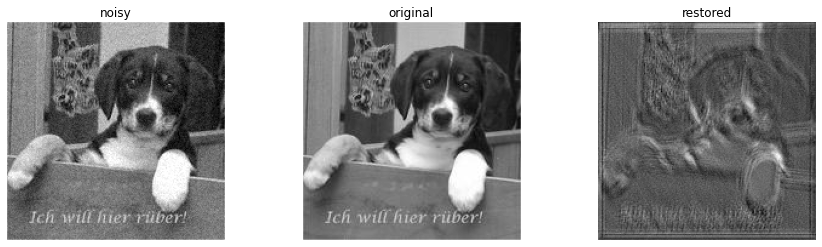

In [ ]:
noisy_image, original_image = testing_set[0]
noisy_image = noisy_image.cuda()
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = noisy_image - predicted_noise

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

## 4. Training
Now that we got everything ready, we should start training, in the next section, you need to implement the training process, that includes defining criteria, setting up optimizer, going through several epochs to train the network, during the training, you should also analyze the psnr scores to see how it goes in terms of quantified performance.

Checklist:
1. define dataloader, recommend batch size starting from 32
2. criteria
3. optimizer
4. (optional) consider using functions in torch.optim.lr_scheduler to adjust your learning rate, because smaller learning rate might work better in the later period of training, similar to fine adjustment. Reference: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
5. during each iteration, you need to 1. get the noisy image and the original image 2. calculate predicted noise from network, use MSE to calculate the distance between predicted noise and true noise 3. reset gradients to zero 3. use the distance as loss to backward the network to get gradients 4. perform learning with the gradients using optimizer
6. From time to time (e.g. each epoch), calculate PSNR on testing_set

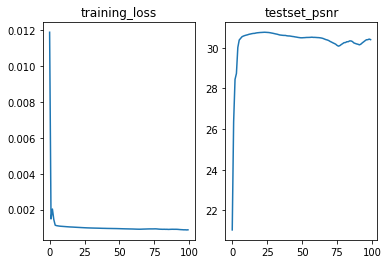

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
import time
from torch.utils.data import DataLoader
import torch.optim as optim
from IPython import display

#training part
training_set_cuda = [[torch.tensor(item[0]).cuda(), torch.tensor(item[1]).cuda()] for item in training_set]
testing_set_cuda = [[torch.tensor(item[0]).cuda(), torch.tensor(item[1]).cuda()] for item in testing_set] # To put both testing set and training set into GPU for faster calculation


def testset_psnr(net, testset): # return the mean psnr of the testset
  total_psnr = 0
  for m in range(len(testset)): # using for loop to interate the testset
    noisy_image = testset[m][0].unsqueeze(0)
    original_image = testset[m][1][0]
    predicted_noise = net(noisy_image).squeeze(0)[0]
    restored_image = original_image.unsqueeze(0) - predicted_noise
    score = psnr(original_image, restored_image[0])
    total_psnr += score
  mean_psnr = total_psnr/len(testset)
  return score

criterion = nn.MSELoss() #Setting up the loos function and the optimizer
optimizer = optim.Adam(net.parameters(),lr=0.001) #Set the learning rate as 0.001

print('start training') #Start training 
training_loss_data = [] #Building up two lists to visualize the trend of loss and mean psnr
testset_psnr_data = []
dl = DataLoader(training_set_cuda,batch_size=32)

for epoch in range(100):
  for data in dl:
    noisy_part = data[0][0]
    original_part = data[1][0]
    current_predicted_noise = net(noisy_part.unsqueeze(0)) # Normal trainging part 
    noise_now = (noisy_part-original_part)
    loss = criterion(current_predicted_noise, noise_now)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  mean_psnr = testset_psnr(net, testing_set_cuda)  # Visualizing the training loss and the psnr using plots
  training_loss_data.append(loss.item())
  net.eval()
  testset_psnr_data.append(mean_psnr)
  net.train()
  fig, ax = plt.subplots(nrows=1, ncols=2)
  ax[0].plot(training_loss_data)
  ax[0].set_title('training_loss')
  ax[1].plot(testset_psnr_data)
  ax[1].set_title('testset_psnr')
  display.clear_output(wait=True)
  plt.show()

Now that your net is ready, we can re do the demonstration.

Text(0.5, 1.0, 'restored')

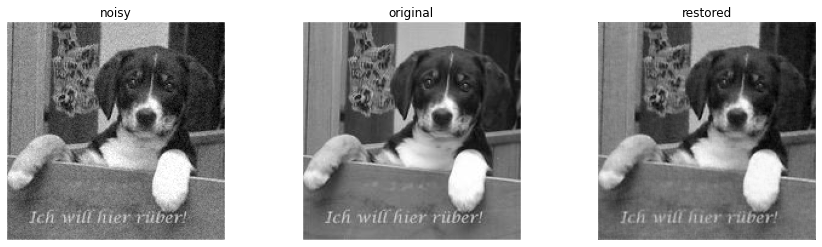

In [ ]:
noisy_image , original_image = testing_set[0]
noisy_image = noisy_image.cuda()
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = noisy_image - predicted_noise

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

The network I trained here is a simple 3-layer low number of channel cnn network, and you can see it's already starting to work. Now try adjust some parameters/network structure to make it work even better. Write down your analysis to make a pdf report.

You need to submit two files, this ipynb file and a pdf report with your analysis.

#Marking Scheme:


*   Code implementation: 60%


> * Dataset 10%
> * Metrics 5%
> * Network 5% (only 5% because network overlaps with results, you need to adjust the network to improve the results anyway)
> * Training code 10%
> * reasonably good results 30% (with 10% bonus if the results are exceptional)


*   PDF report: 40%

> * Basic results demonstration (network introduction, denoising results showcase) 15%
> * Analysis and improvements 25% (You're supposed to clarify how do you make the network work, e.g. if you encounter some issues, what do you do to address them)

